In [37]:
from dataclasses import dataclass
from pathlib import Path
import pickle
from typing import Optional

from jaxtyping import Float
from omegaconf import OmegaConf, DictConfig
import yaml
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import r2_score
import torch
from tqdm.auto import tqdm

from src.encoding.ecog import ContrastiveModelSnapshot, AlignedECoGDataset, get_electrode_df, OutFile
from src.encoding.ecog import timit as timit_encoding

In [14]:
dataset = "timit"
rsa_analysis = "rsa_1"

encoder_dirs = list(Path(f"outputs/encoders/{dataset}").glob("*/*"))
rsa_dirs = list(Path(f"outputs/rsa/{dataset}/{rsa_analysis}").glob("*/*/*"))

In [15]:
encoder_dir_dict = {(p.parent.name, p.name): p for p in encoder_dirs}
rsa_dir_dict = {(p.parent.parent.name, p.parent.name, p.name): p for p in rsa_dirs}

## Compute encoder improvements

In [32]:
def get_baseline_predictions(encoder_path):
    with (Path(encoder_path) / ".hydra" / "config.yaml").open() as f:
        config = OmegaConf.create(yaml.safe_load(f))
    return np.load(Path(encoder_path) / "predictions.npy")


@dataclass
class EncoderPredictions:

    config: DictConfig
    feature_spec: DictConfig
    data_spec: DictConfig

    out: OutFile
    electrode_df: pd.DataFrame

    Y: np.ndarray
    trial_onsets: np.ndarray
    predictions: np.ndarray

    @classmethod
    def from_encoder_path(cls, encoder_path):
        with (Path(encoder_path) / ".hydra" / "config.yaml").open() as f:
            config = OmegaConf.create(yaml.safe_load(f))
        feature_spec = next(iter(config.feature_sets.model_features.values()))

        data_spec = next(iter(config.data))
        out = timit_encoding.prepare_out_file(config, data_spec)

        electrode_df = get_electrode_df(config, data_spec.subject)

        X, Y, _, _, trial_onsets = timit_encoding.prepare_xy(config, data_spec)

        predictions = np.load(Path(encoder_path) / "predictions.npy")

        # Validate saved predictions with re-constructed design matrix / features
        assert predictions.shape == Y.shape

        return cls(
            config=config,
            feature_spec=feature_spec,
            data_spec=data_spec,

            out=out,
            electrode_df=electrode_df,

            Y=Y,
            trial_onsets=trial_onsets,
            predictions=predictions,
        )
    

def compute_trial_improvements(encoder_predictions: EncoderPredictions, baseline_predictions: np.ndarray):
    trial_predictions = np.split(encoder_predictions.predictions, encoder_predictions.trial_onsets[1:, 1], axis=0)
    trial_baseline_predictions = np.split(baseline_predictions, encoder_predictions.trial_onsets[1:, 1], axis=0)
    trial_Y = np.split(encoder_predictions.Y, encoder_predictions.trial_onsets[1:, 1], axis=0)
    trial_names = [encoder_predictions.out[idx]["name"] for idx in encoder_predictions.trial_onsets[:, 0]]

    # Compute R^2 within each trial and electrode
    trial_r2: Float[np.ndarray, "num_trials num_electrodes"] = np.array([r2_score(y, p, multioutput="raw_values") for y, p in zip(trial_Y, trial_predictions)])
    trial_baseline_r2 = np.array([r2_score(y, p, multioutput="raw_values") for y, p in zip(trial_Y, trial_baseline_predictions)])
    trial_r2_change = trial_r2 - trial_baseline_r2

    # Compute L2 distance by trial, electrode, time sample
    trial_l2 = [(y - p) ** 2 for y, p in zip(trial_Y, trial_predictions)]
    trial_baseline_l2 = [(y - p) ** 2 for y, p in zip(trial_Y, trial_baseline_predictions)]
    trial_l2_change = [bl - l for l, bl in zip(trial_l2, trial_baseline_l2)]

    # Pad into regular matrix
    max_len = max(len(l) for l in trial_l2)
    trial_l2_padded: Float[np.ndarray, "num_trials max_num_samples num_electrodes"] = \
        np.array([np.pad(l, ((0, max_len - len(l)), (0, 0)), mode="constant", constant_values=np.nan) for l in trial_l2])
    trial_baseline_l2_padded = np.array([np.pad(l, ((0, max_len - len(l)), (0, 0)), mode="constant", constant_values=np.nan) for l in trial_baseline_l2])
    trial_l2_change_padded = np.array([np.pad(l, ((0, max_len - len(l)), (0, 0)), mode="constant", constant_values=np.nan) for l in trial_l2_change])

    return {
        "trial_r2": trial_r2,
        "trial_baseline_r2": trial_baseline_r2,
        "trial_r2_change": trial_r2_change,

        "trial_l2": trial_l2_padded,
        "trial_baseline_l2": trial_baseline_l2_padded,
        "trial_l2_change": trial_l2_change_padded,

        "trial_names": trial_names,
    }

In [33]:
# Compute baseline predictions first
baseline_predictions = {}
subjects = sorted(set(subject for model_embedding, subject in encoder_dir_dict.keys()))
for subject in tqdm(subjects):
    baseline_path = encoder_dir_dict["baseline", subject]
    baseline_predictions[subject] = get_baseline_predictions(baseline_path)

  0%|          | 0/6 [00:00<?, ?it/s]

In [34]:
trial_improvements = {}
for (model_embedding, subject), encoder_dir in tqdm(list(encoder_dir_dict.items())):
    if model_embedding == "baseline":
        continue
    if subject not in baseline_predictions:
        continue

    encoder_predictions = EncoderPredictions.from_encoder_path(encoder_dir)
    trial_improvements[model_embedding, subject] = compute_trial_improvements(encoder_predictions, baseline_predictions[subject])

  0%|          | 0/48 [00:00<?, ?it/s]

Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Aligning model embeddings:   0%|          | 0/499 [00:00<?, ?it/s]

/userdata/jgauthier/projects/ideal-word-representations/src/encoding/ecog/timit.py:111: RuntimeWarning: Mean of empty slice.
  unit_embedding = model.embeddings[unit_start:unit_end].mean(axis=0)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
Coercing non-float feature onset with dtype uint8 to float
Feature model_embedding has 282 samples, expected 280. Trimming but you should check this!
Feature samples (280) do not match response samples (282). Trimming response
Feature samples (323) do not match response samples (326). Trimming response
Feature samples (354) do not match response samples (356). Trimming response
Feature samples (350) do not match response samples (353). Trimming response
Feature samples (248) do not match response samples (250). Trimming response
Feature samples (306) do not match response samples (308). Trimming response
Feature samples (346) do not 

Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Aligning model embeddings:   0%|          | 0/499 [00:00<?, ?it/s]

/userdata/jgauthier/projects/ideal-word-representations/src/encoding/ecog/timit.py:111: RuntimeWarning: Mean of empty slice.
  unit_embedding = model.embeddings[unit_start:unit_end].mean(axis=0)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
Coercing non-float feature onset with dtype uint8 to float
Feature model_embedding has 282 samples, expected 280. Trimming but you should check this!
Feature samples (280) do not match response samples (282). Trimming response
Feature samples (323) do not match response samples (326). Trimming response
Feature samples (354) do not match response samples (356). Trimming response
Feature samples (350) do not match response samples (353). Trimming response
Feature samples (248) do not match response samples (250). Trimming response
Feature samples (306) do not match response samples (308). Trimming response
Feature samples (346) do not 

Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Aligning model embeddings:   0%|          | 0/499 [00:00<?, ?it/s]

/userdata/jgauthier/projects/ideal-word-representations/src/encoding/ecog/timit.py:111: RuntimeWarning: Mean of empty slice.
  unit_embedding = model.embeddings[unit_start:unit_end].mean(axis=0)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
Coercing non-float feature onset with dtype uint8 to float
Feature model_embedding has 282 samples, expected 280. Trimming but you should check this!
Feature samples (280) do not match response samples (282). Trimming response
Feature samples (323) do not match response samples (326). Trimming response
Feature samples (354) do not match response samples (356). Trimming response
Feature samples (350) do not match response samples (353). Trimming response
Feature samples (248) do not match response samples (250). Trimming response
Feature samples (306) do not match response samples (308). Trimming response
Feature samples (346) do not 

Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Aligning model embeddings:   0%|          | 0/499 [00:00<?, ?it/s]

/userdata/jgauthier/projects/ideal-word-representations/src/encoding/ecog/timit.py:111: RuntimeWarning: Mean of empty slice.
  unit_embedding = model.embeddings[unit_start:unit_end].mean(axis=0)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
Coercing non-float feature onset with dtype uint8 to float


Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Aligning model embeddings:   0%|          | 0/129 [00:00<?, ?it/s]

/userdata/jgauthier/projects/ideal-word-representations/src/encoding/ecog/timit.py:111: RuntimeWarning: Mean of empty slice.
  unit_embedding = model.embeddings[unit_start:unit_end].mean(axis=0)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
Coercing non-float feature onset with dtype uint8 to float


Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Aligning model embeddings:   0%|          | 0/252 [00:00<?, ?it/s]

/userdata/jgauthier/projects/ideal-word-representations/src/encoding/ecog/timit.py:111: RuntimeWarning: Mean of empty slice.
  unit_embedding = model.embeddings[unit_start:unit_end].mean(axis=0)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
Coercing non-float feature onset with dtype uint8 to float


Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Aligning model embeddings:   0%|          | 0/252 [00:00<?, ?it/s]

Coercing non-float feature onset with dtype uint8 to float


Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Aligning model embeddings:   0%|          | 0/129 [00:00<?, ?it/s]

Coercing non-float feature onset with dtype uint8 to float


Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Aligning model embeddings:   0%|          | 0/499 [00:00<?, ?it/s]

Coercing non-float feature onset with dtype uint8 to float


Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Aligning model embeddings:   0%|          | 0/499 [00:00<?, ?it/s]

Coercing non-float feature onset with dtype uint8 to float
Feature model_embedding has 282 samples, expected 280. Trimming but you should check this!
Feature samples (280) do not match response samples (282). Trimming response
Feature samples (323) do not match response samples (326). Trimming response
Feature samples (354) do not match response samples (356). Trimming response
Feature samples (350) do not match response samples (353). Trimming response
Feature samples (248) do not match response samples (250). Trimming response
Feature samples (306) do not match response samples (308). Trimming response
Feature samples (346) do not match response samples (348). Trimming response
Feature samples (331) do not match response samples (333). Trimming response
Feature samples (311) do not match response samples (314). Trimming response
Feature samples (327) do not match response samples (330). Trimming response
Feature samples (247) do not match response samples (250). Trimming response
Fea

Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Aligning model embeddings:   0%|          | 0/499 [00:00<?, ?it/s]

Coercing non-float feature onset with dtype uint8 to float
Feature model_embedding has 282 samples, expected 280. Trimming but you should check this!
Feature samples (280) do not match response samples (282). Trimming response
Feature samples (323) do not match response samples (326). Trimming response
Feature samples (354) do not match response samples (356). Trimming response
Feature samples (350) do not match response samples (353). Trimming response
Feature samples (248) do not match response samples (250). Trimming response
Feature samples (306) do not match response samples (308). Trimming response
Feature samples (346) do not match response samples (348). Trimming response
Feature samples (331) do not match response samples (333). Trimming response
Feature samples (311) do not match response samples (314). Trimming response
Feature samples (327) do not match response samples (330). Trimming response
Feature samples (247) do not match response samples (250). Trimming response
Fea

Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Aligning model embeddings:   0%|          | 0/499 [00:00<?, ?it/s]

Coercing non-float feature onset with dtype uint8 to float
Feature model_embedding has 282 samples, expected 280. Trimming but you should check this!
Feature samples (280) do not match response samples (282). Trimming response
Feature samples (323) do not match response samples (326). Trimming response
Feature samples (354) do not match response samples (356). Trimming response
Feature samples (350) do not match response samples (353). Trimming response
Feature samples (248) do not match response samples (250). Trimming response
Feature samples (306) do not match response samples (308). Trimming response
Feature samples (346) do not match response samples (348). Trimming response
Feature samples (331) do not match response samples (333). Trimming response
Feature samples (311) do not match response samples (314). Trimming response
Feature samples (327) do not match response samples (330). Trimming response
Feature samples (247) do not match response samples (250). Trimming response
Fea

Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Aligning model embeddings:   0%|          | 0/499 [00:00<?, ?it/s]

/userdata/jgauthier/projects/ideal-word-representations/src/encoding/ecog/timit.py:111: RuntimeWarning: Mean of empty slice.
  unit_embedding = model.embeddings[unit_start:unit_end].mean(axis=0)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
Coercing non-float feature onset with dtype uint8 to float


Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Aligning model embeddings:   0%|          | 0/252 [00:00<?, ?it/s]

/userdata/jgauthier/projects/ideal-word-representations/src/encoding/ecog/timit.py:111: RuntimeWarning: Mean of empty slice.
  unit_embedding = model.embeddings[unit_start:unit_end].mean(axis=0)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
Coercing non-float feature onset with dtype uint8 to float


Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Aligning model embeddings:   0%|          | 0/129 [00:00<?, ?it/s]

/userdata/jgauthier/projects/ideal-word-representations/src/encoding/ecog/timit.py:111: RuntimeWarning: Mean of empty slice.
  unit_embedding = model.embeddings[unit_start:unit_end].mean(axis=0)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
Coercing non-float feature onset with dtype uint8 to float


Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Aligning model embeddings:   0%|          | 0/499 [00:00<?, ?it/s]

/userdata/jgauthier/projects/ideal-word-representations/src/encoding/ecog/timit.py:111: RuntimeWarning: Mean of empty slice.
  unit_embedding = model.embeddings[unit_start:unit_end].mean(axis=0)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
Coercing non-float feature onset with dtype uint8 to float
Feature model_embedding has 282 samples, expected 280. Trimming but you should check this!
Feature samples (280) do not match response samples (282). Trimming response
Feature samples (323) do not match response samples (326). Trimming response
Feature samples (354) do not match response samples (356). Trimming response
Feature samples (350) do not match response samples (353). Trimming response
Feature samples (248) do not match response samples (250). Trimming response
Feature samples (306) do not match response samples (308). Trimming response
Feature samples (346) do not 

Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Aligning model embeddings:   0%|          | 0/499 [00:00<?, ?it/s]

/userdata/jgauthier/projects/ideal-word-representations/src/encoding/ecog/timit.py:111: RuntimeWarning: Mean of empty slice.
  unit_embedding = model.embeddings[unit_start:unit_end].mean(axis=0)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
Coercing non-float feature onset with dtype uint8 to float
Feature model_embedding has 282 samples, expected 280. Trimming but you should check this!
Feature samples (280) do not match response samples (282). Trimming response
Feature samples (323) do not match response samples (326). Trimming response
Feature samples (354) do not match response samples (356). Trimming response
Feature samples (350) do not match response samples (353). Trimming response
Feature samples (248) do not match response samples (250). Trimming response
Feature samples (306) do not match response samples (308). Trimming response
Feature samples (346) do not 

Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Aligning model embeddings:   0%|          | 0/499 [00:00<?, ?it/s]

/userdata/jgauthier/projects/ideal-word-representations/src/encoding/ecog/timit.py:111: RuntimeWarning: Mean of empty slice.
  unit_embedding = model.embeddings[unit_start:unit_end].mean(axis=0)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
Coercing non-float feature onset with dtype uint8 to float
Feature model_embedding has 282 samples, expected 280. Trimming but you should check this!
Feature samples (280) do not match response samples (282). Trimming response
Feature samples (323) do not match response samples (326). Trimming response
Feature samples (354) do not match response samples (356). Trimming response
Feature samples (350) do not match response samples (353). Trimming response
Feature samples (248) do not match response samples (250). Trimming response
Feature samples (306) do not match response samples (308). Trimming response
Feature samples (346) do not 

Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Aligning model embeddings:   0%|          | 0/252 [00:00<?, ?it/s]

Coercing non-float feature onset with dtype uint8 to float


Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Aligning model embeddings:   0%|          | 0/129 [00:00<?, ?it/s]

Coercing non-float feature onset with dtype uint8 to float


Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Aligning model embeddings:   0%|          | 0/499 [00:00<?, ?it/s]

Coercing non-float feature onset with dtype uint8 to float


Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Aligning model embeddings:   0%|          | 0/499 [00:00<?, ?it/s]

Coercing non-float feature onset with dtype uint8 to float
Feature model_embedding has 282 samples, expected 280. Trimming but you should check this!
Feature samples (280) do not match response samples (282). Trimming response
Feature samples (323) do not match response samples (326). Trimming response
Feature samples (354) do not match response samples (356). Trimming response
Feature samples (350) do not match response samples (353). Trimming response
Feature samples (248) do not match response samples (250). Trimming response
Feature samples (306) do not match response samples (308). Trimming response
Feature samples (346) do not match response samples (348). Trimming response
Feature samples (331) do not match response samples (333). Trimming response
Feature samples (311) do not match response samples (314). Trimming response
Feature samples (327) do not match response samples (330). Trimming response
Feature samples (247) do not match response samples (250). Trimming response
Fea

Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Aligning model embeddings:   0%|          | 0/499 [00:00<?, ?it/s]

Coercing non-float feature onset with dtype uint8 to float
Feature model_embedding has 282 samples, expected 280. Trimming but you should check this!
Feature samples (280) do not match response samples (282). Trimming response
Feature samples (323) do not match response samples (326). Trimming response
Feature samples (354) do not match response samples (356). Trimming response
Feature samples (350) do not match response samples (353). Trimming response
Feature samples (248) do not match response samples (250). Trimming response
Feature samples (306) do not match response samples (308). Trimming response
Feature samples (346) do not match response samples (348). Trimming response
Feature samples (331) do not match response samples (333). Trimming response
Feature samples (311) do not match response samples (314). Trimming response
Feature samples (327) do not match response samples (330). Trimming response
Feature samples (247) do not match response samples (250). Trimming response
Fea

Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Aligning model embeddings:   0%|          | 0/499 [00:00<?, ?it/s]

Coercing non-float feature onset with dtype uint8 to float
Feature model_embedding has 282 samples, expected 280. Trimming but you should check this!
Feature samples (280) do not match response samples (282). Trimming response
Feature samples (323) do not match response samples (326). Trimming response
Feature samples (354) do not match response samples (356). Trimming response
Feature samples (350) do not match response samples (353). Trimming response
Feature samples (248) do not match response samples (250). Trimming response
Feature samples (306) do not match response samples (308). Trimming response
Feature samples (346) do not match response samples (348). Trimming response
Feature samples (331) do not match response samples (333). Trimming response
Feature samples (311) do not match response samples (314). Trimming response
Feature samples (327) do not match response samples (330). Trimming response
Feature samples (247) do not match response samples (250). Trimming response
Fea

Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Aligning model embeddings:   0%|          | 0/499 [00:00<?, ?it/s]

/userdata/jgauthier/projects/ideal-word-representations/src/encoding/ecog/timit.py:111: RuntimeWarning: Mean of empty slice.
  unit_embedding = model.embeddings[unit_start:unit_end].mean(axis=0)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
Coercing non-float feature onset with dtype uint8 to float
Feature model_embedding has 282 samples, expected 280. Trimming but you should check this!
Feature samples (280) do not match response samples (282). Trimming response
Feature samples (323) do not match response samples (326). Trimming response
Feature samples (354) do not match response samples (356). Trimming response
Feature samples (350) do not match response samples (353). Trimming response
Feature samples (248) do not match response samples (250). Trimming response
Feature samples (306) do not match response samples (308). Trimming response
Feature samples (346) do not 

Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Aligning model embeddings:   0%|          | 0/499 [00:00<?, ?it/s]

/userdata/jgauthier/projects/ideal-word-representations/src/encoding/ecog/timit.py:111: RuntimeWarning: Mean of empty slice.
  unit_embedding = model.embeddings[unit_start:unit_end].mean(axis=0)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
Coercing non-float feature onset with dtype uint8 to float
Feature model_embedding has 282 samples, expected 280. Trimming but you should check this!
Feature samples (280) do not match response samples (282). Trimming response
Feature samples (323) do not match response samples (326). Trimming response
Feature samples (354) do not match response samples (356). Trimming response
Feature samples (350) do not match response samples (353). Trimming response
Feature samples (248) do not match response samples (250). Trimming response
Feature samples (306) do not match response samples (308). Trimming response
Feature samples (346) do not 

Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Aligning model embeddings:   0%|          | 0/499 [00:00<?, ?it/s]

/userdata/jgauthier/projects/ideal-word-representations/src/encoding/ecog/timit.py:111: RuntimeWarning: Mean of empty slice.
  unit_embedding = model.embeddings[unit_start:unit_end].mean(axis=0)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
Coercing non-float feature onset with dtype uint8 to float
Feature model_embedding has 282 samples, expected 280. Trimming but you should check this!
Feature samples (280) do not match response samples (282). Trimming response
Feature samples (323) do not match response samples (326). Trimming response
Feature samples (354) do not match response samples (356). Trimming response
Feature samples (350) do not match response samples (353). Trimming response
Feature samples (248) do not match response samples (250). Trimming response
Feature samples (306) do not match response samples (308). Trimming response
Feature samples (346) do not 

Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Aligning model embeddings:   0%|          | 0/129 [00:00<?, ?it/s]

/userdata/jgauthier/projects/ideal-word-representations/src/encoding/ecog/timit.py:111: RuntimeWarning: Mean of empty slice.
  unit_embedding = model.embeddings[unit_start:unit_end].mean(axis=0)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
Coercing non-float feature onset with dtype uint8 to float


Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Aligning model embeddings:   0%|          | 0/252 [00:00<?, ?it/s]

/userdata/jgauthier/projects/ideal-word-representations/src/encoding/ecog/timit.py:111: RuntimeWarning: Mean of empty slice.
  unit_embedding = model.embeddings[unit_start:unit_end].mean(axis=0)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
Coercing non-float feature onset with dtype uint8 to float


Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Aligning model embeddings:   0%|          | 0/499 [00:00<?, ?it/s]

/userdata/jgauthier/projects/ideal-word-representations/src/encoding/ecog/timit.py:111: RuntimeWarning: Mean of empty slice.
  unit_embedding = model.embeddings[unit_start:unit_end].mean(axis=0)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
Coercing non-float feature onset with dtype uint8 to float


Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Aligning model embeddings:   0%|          | 0/252 [00:00<?, ?it/s]

/userdata/jgauthier/projects/ideal-word-representations/src/encoding/ecog/timit.py:111: RuntimeWarning: Mean of empty slice.
  unit_embedding = model.embeddings[unit_start:unit_end].mean(axis=0)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
Coercing non-float feature onset with dtype uint8 to float


Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Aligning model embeddings:   0%|          | 0/129 [00:00<?, ?it/s]

/userdata/jgauthier/projects/ideal-word-representations/src/encoding/ecog/timit.py:111: RuntimeWarning: Mean of empty slice.
  unit_embedding = model.embeddings[unit_start:unit_end].mean(axis=0)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
Coercing non-float feature onset with dtype uint8 to float


Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Aligning model embeddings:   0%|          | 0/499 [00:00<?, ?it/s]

/userdata/jgauthier/projects/ideal-word-representations/src/encoding/ecog/timit.py:111: RuntimeWarning: Mean of empty slice.
  unit_embedding = model.embeddings[unit_start:unit_end].mean(axis=0)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
Coercing non-float feature onset with dtype uint8 to float


Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Aligning model embeddings:   0%|          | 0/499 [00:00<?, ?it/s]

/userdata/jgauthier/projects/ideal-word-representations/src/encoding/ecog/timit.py:111: RuntimeWarning: Mean of empty slice.
  unit_embedding = model.embeddings[unit_start:unit_end].mean(axis=0)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
Coercing non-float feature onset with dtype uint8 to float
Feature model_embedding has 282 samples, expected 280. Trimming but you should check this!
Feature samples (280) do not match response samples (282). Trimming response
Feature samples (323) do not match response samples (326). Trimming response
Feature samples (354) do not match response samples (356). Trimming response
Feature samples (350) do not match response samples (353). Trimming response
Feature samples (248) do not match response samples (250). Trimming response
Feature samples (306) do not match response samples (308). Trimming response
Feature samples (346) do not 

Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Aligning model embeddings:   0%|          | 0/499 [00:00<?, ?it/s]

/userdata/jgauthier/projects/ideal-word-representations/src/encoding/ecog/timit.py:111: RuntimeWarning: Mean of empty slice.
  unit_embedding = model.embeddings[unit_start:unit_end].mean(axis=0)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
Coercing non-float feature onset with dtype uint8 to float
Feature model_embedding has 282 samples, expected 280. Trimming but you should check this!
Feature samples (280) do not match response samples (282). Trimming response
Feature samples (323) do not match response samples (326). Trimming response
Feature samples (354) do not match response samples (356). Trimming response
Feature samples (350) do not match response samples (353). Trimming response
Feature samples (248) do not match response samples (250). Trimming response
Feature samples (306) do not match response samples (308). Trimming response
Feature samples (346) do not 

Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Aligning model embeddings:   0%|          | 0/499 [00:00<?, ?it/s]

/userdata/jgauthier/projects/ideal-word-representations/src/encoding/ecog/timit.py:111: RuntimeWarning: Mean of empty slice.
  unit_embedding = model.embeddings[unit_start:unit_end].mean(axis=0)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
Coercing non-float feature onset with dtype uint8 to float
Feature model_embedding has 282 samples, expected 280. Trimming but you should check this!
Feature samples (280) do not match response samples (282). Trimming response
Feature samples (323) do not match response samples (326). Trimming response
Feature samples (354) do not match response samples (356). Trimming response
Feature samples (350) do not match response samples (353). Trimming response
Feature samples (248) do not match response samples (250). Trimming response
Feature samples (306) do not match response samples (308). Trimming response
Feature samples (346) do not 

Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Aligning model embeddings:   0%|          | 0/499 [00:00<?, ?it/s]

/userdata/jgauthier/projects/ideal-word-representations/src/encoding/ecog/timit.py:111: RuntimeWarning: Mean of empty slice.
  unit_embedding = model.embeddings[unit_start:unit_end].mean(axis=0)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
Coercing non-float feature onset with dtype uint8 to float
Feature model_embedding has 282 samples, expected 280. Trimming but you should check this!
Feature samples (280) do not match response samples (282). Trimming response
Feature samples (323) do not match response samples (326). Trimming response
Feature samples (354) do not match response samples (356). Trimming response
Feature samples (350) do not match response samples (353). Trimming response
Feature samples (248) do not match response samples (250). Trimming response
Feature samples (306) do not match response samples (308). Trimming response
Feature samples (346) do not 

Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Aligning model embeddings:   0%|          | 0/499 [00:00<?, ?it/s]

/userdata/jgauthier/projects/ideal-word-representations/src/encoding/ecog/timit.py:111: RuntimeWarning: Mean of empty slice.
  unit_embedding = model.embeddings[unit_start:unit_end].mean(axis=0)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
Coercing non-float feature onset with dtype uint8 to float
Feature model_embedding has 282 samples, expected 280. Trimming but you should check this!
Feature samples (280) do not match response samples (282). Trimming response
Feature samples (323) do not match response samples (326). Trimming response
Feature samples (354) do not match response samples (356). Trimming response
Feature samples (350) do not match response samples (353). Trimming response
Feature samples (248) do not match response samples (250). Trimming response
Feature samples (306) do not match response samples (308). Trimming response
Feature samples (346) do not 

Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Aligning model embeddings:   0%|          | 0/499 [00:00<?, ?it/s]

/userdata/jgauthier/projects/ideal-word-representations/src/encoding/ecog/timit.py:111: RuntimeWarning: Mean of empty slice.
  unit_embedding = model.embeddings[unit_start:unit_end].mean(axis=0)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
Coercing non-float feature onset with dtype uint8 to float
Feature model_embedding has 282 samples, expected 280. Trimming but you should check this!
Feature samples (280) do not match response samples (282). Trimming response
Feature samples (323) do not match response samples (326). Trimming response
Feature samples (354) do not match response samples (356). Trimming response
Feature samples (350) do not match response samples (353). Trimming response
Feature samples (248) do not match response samples (250). Trimming response
Feature samples (306) do not match response samples (308). Trimming response
Feature samples (346) do not 

Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Aligning model embeddings:   0%|          | 0/499 [00:00<?, ?it/s]

/userdata/jgauthier/projects/ideal-word-representations/src/encoding/ecog/timit.py:111: RuntimeWarning: Mean of empty slice.
  unit_embedding = model.embeddings[unit_start:unit_end].mean(axis=0)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
Coercing non-float feature onset with dtype uint8 to float


Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Aligning model embeddings:   0%|          | 0/252 [00:00<?, ?it/s]

/userdata/jgauthier/projects/ideal-word-representations/src/encoding/ecog/timit.py:111: RuntimeWarning: Mean of empty slice.
  unit_embedding = model.embeddings[unit_start:unit_end].mean(axis=0)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
Coercing non-float feature onset with dtype uint8 to float


Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Aligning model embeddings:   0%|          | 0/129 [00:00<?, ?it/s]

/userdata/jgauthier/projects/ideal-word-representations/src/encoding/ecog/timit.py:111: RuntimeWarning: Mean of empty slice.
  unit_embedding = model.embeddings[unit_start:unit_end].mean(axis=0)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
Coercing non-float feature onset with dtype uint8 to float


In [38]:
with open("trial_improvements.pkl", "wb") as f:
    pickle.dump(trial_improvements, f)

### Electrode selection by encoder improvements within-subject

In [48]:
electrode_dfs = {}
with (Path(encoder_dirs[0]) / ".hydra" / "config.yaml").open() as f:
    dummy_config = OmegaConf.create(yaml.safe_load(f))
for subject in subjects:
    electrode_dfs[subject] = get_electrode_df(dummy_config, subject)
electrode_df = pd.concat(electrode_dfs, names=["subject"])
electrode_df

long_name   type  \
subject electrode_idx electrode_name                           
EC152   0             G1              RGridElectrode1   grid   
        1             G2              RGridElectrode2   grid   
        2             G3              RGridElectrode3   grid   
        3             G4              RGridElectrode4   grid   
        4             G5              RGridElectrode5   grid   
...                                               ...    ...   
EC260   313           ID6                     Insula6  depth   
        314           ID7                     Insula7  depth   
        315           ID8                     Insula8  depth   
        316           ID9                     Insula9  depth   
        317           ID10                   Insula10  depth   

                                                               roi  
subject electrode_idx electrode_name                                
EC152   0             G1                            middletemporal  
        1             G2                            middletemporal  
        2             G3                          superiortemporal  
        3             G4                          superiortemporal  
        4             G5                          superiortemporal  
...                                                            ...  
EC260   313           ID6               Left-Cerebral-White-Matter  
        314           ID7             ctx_lh_S_precentral-inf-part  
        315           ID8             ctx_lh_S_precentral-inf-part  
        316           ID9               Left-Cerebral-White-Matter  
        317           ID10                   ctx_lh_G_front_middle  

[2016 rows x 3 columns]

In [65]:
k = 5
top_k = {}
max_trial_r2_change_df = {}
for (model_embedding, subject), trial_improvement in tqdm(trial_improvements.items()):
    electrode_scores = trial_improvement["trial_r2_change"].max(axis=0)
    max_trial_r2_change_df[model_embedding, subject] = \
        pd.DataFrame(electrode_scores,
                     index=electrode_df.loc[subject].index[:len(electrode_scores)],
                     columns=["max_trial_r2_change"])
    top_k[model_embedding, subject] = np.argsort(electrode_scores)[-k:]

  0%|          | 0/42 [00:00<?, ?it/s]

In [68]:
max_trial_r2_change_df = pd.concat(max_trial_r2_change_df, names=["model_embedding", "subject"])
max_trial_r2_change_df

max_trial_r2_change
model_embedding subject electrode_idx electrode_name                     
random8         EC195   0             GP1                        0.000948
                        1             GP2                        0.000322
                        2             GP3                        0.000188
                        3             GP4                        0.000299
                        4             GP5                        0.000278
...                                                                   ...
biphone_recon   EC152   251           G252                       0.000465
                        252           G253                       0.000552
                        253           G254                       0.000498
                        254           G255                       0.000454
                        255           G256                       0.000975

[11648 rows x 1 columns]

In [61]:
top_k_df = pd.DataFrame(top_k).T
top_k_df.index.set_names(["model_embedding", "subject"], inplace=True)
top_k_df = top_k_df.reset_index().melt(id_vars=["model_embedding", "subject"], var_name="drop", value_name="electrode_idx").drop(columns=["drop"])

In [85]:
top_k_df.to_csv("top_k-across_subject.csv")

In [81]:
top_k_plot_df = pd.merge(top_k_df.drop(columns=["model_embedding"]).drop_duplicates(),
         max_trial_r2_change_df.reset_index().set_index(["subject", "electrode_idx"]), how="left",
         left_on=["subject", "electrode_idx"], right_index=True)
# normalize change within-subject
top_k_plot_df["max_trial_r2_change_normalized"] = top_k_plot_df.groupby("subject")["max_trial_r2_change"].transform(lambda x: x / x.max())

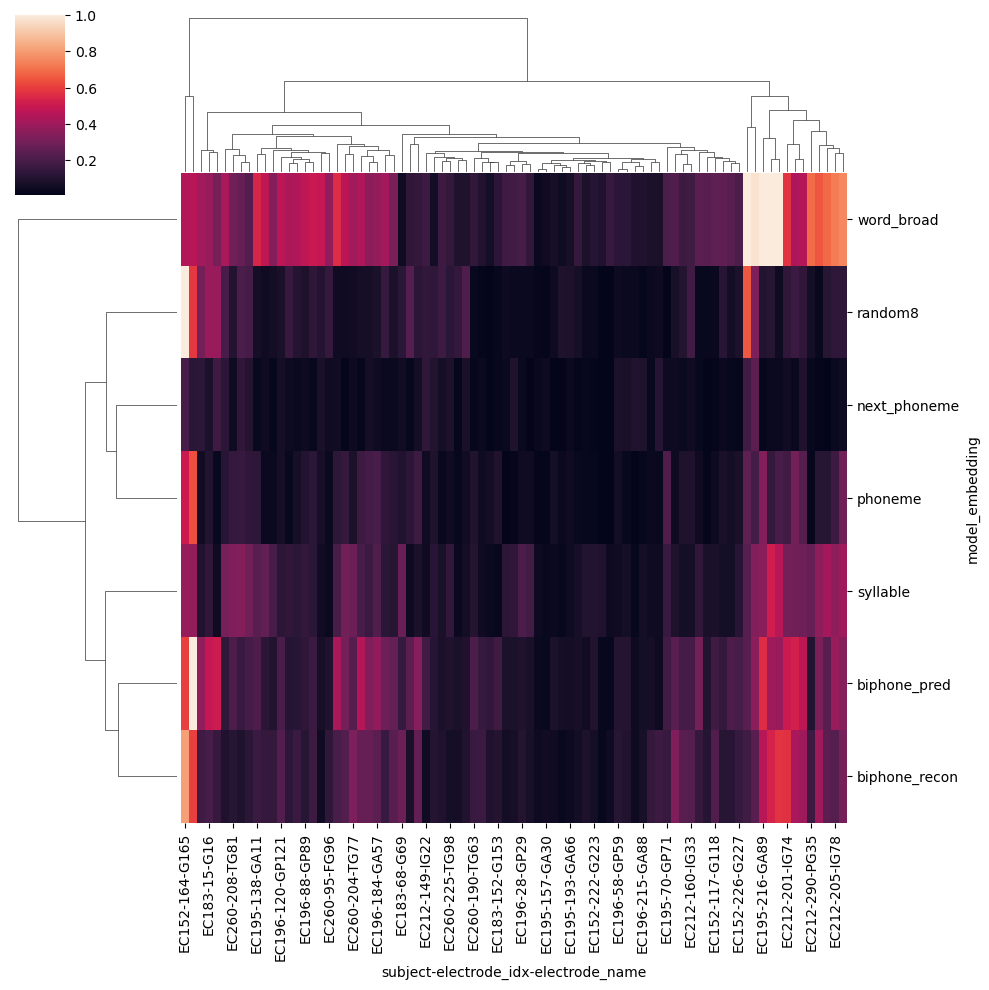

In [82]:
sns.clustermap(top_k_plot_df.pivot_table(index="model_embedding",
                                     columns=["subject", "electrode_idx", "electrode_name"],
                                     values="max_trial_r2_change_normalized"))

In [83]:
top_k_plot_df.to_csv("predictions_across_subject-top_k.csv")